(content:references:sed_part3)=
# Spectral Energy Distribution (SED) Part 3: *Bayesian Evidence and Model Selection*

***Author: Marc Hon***

In this chapter, we will explore the use of machine learning to guide Bayesian model selection in fitting SEDs.


## Excess flux in SEDs


Close companions of stars, if sufficiently luminous, can pollute the incoming light expected from a source. Due to the finite angular resolution of telescopes, it is common that light measurements of astronomical sources may be **blended** with a nearby target, such that you measure the light from two or more sources.


```{figure} images/unresolved.png
---
height: 200px
width: 800px
name: unresolved
---
An example of a binary system with an on-sky separation smaller than 0.5 arcseconds. Pesky! The two stars are only able to be resolved with a telescope with sufficient angular resolving power. Image from [Adams et al. (2012)](https://iopscience.iop.org/article/10.1088/0004-6256/144/2/42/pdf)
```

If the companion(s) to the primary source are sufficiently luminous, you may observe their flux contribution superimposed on the target source's SED as a **flux excess**.

In [2]:
import os
import yaml
import emcee
import corner
import pyphot
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import astropy.constants as const
import pysynphot as S
import extinction

from pathlib import Path
from astropy.io import fits
from matplotlib import cm
from matplotlib.colors import Normalize
from astropy.modeling.models import BlackBody
from astropy import coordinates as coords
from scipy.stats import truncnorm, norm
from numpy import log, sqrt, pi
from scipy.special import erf
from isochrones.interp import DFInterpolator
from extinction import apply


data_folder_path = Path.cwd().resolve().parent.parent / 'ml_astro' / 'chapter2' / 'data'
os.environ['PYSYN_CDBS'] = str(data_folder_path)

plt.style.use('science')

fs = 18

def mag_to_flux_AB(mag, mag_err):
    """Calculate flux in erg s-1 cm-2 Hz-1."""
    flux = 10 ** (-.4 * (mag + 48.6))
    flux_err = abs(-.4 * flux * np.log(10) * mag_err)
    return flux, flux_err


def get_zero_flux(band):
    """Look for the filter information in the pyphot library of filters."""
    # Load photometry filter library
    filt = pyphot.get_library()[band]
    # Get Vega zero flux in erg / cm2 / s / AA
    f0 = filt.Vega_zero_flux.to('erg/(AA * cm ** 2 * s)').magnitude
    return f0


def get_effective_wavelength(band):
    """Get central wavelength of a specific filter in um."""
    # Load photometry filter library
    filt = pyphot.get_library()[band]
    # Get central wavelength in um
    leff = filt.cl.to('AA').magnitude
    return leff

def convert_f_nu_to_f_lambda(f, l):
    """Convert flux from erf s-1 cm-2 Hz-1 to erg s-1 cm-2 lambda-1."""
    return f * const.c.to(u.AA / u.s).value / l ** 2


def mag_to_flux(mag, mag_err, band):
    """Convert from magnitude to flux.

    mag_to_flux performs the conversion from magnitude to flux in
    erg s-1 cm-2 AA-1.5

    The band parameter is a string representing the filter used and it must
    match exactly the name in pyphots filter database

    If the filter is from PanSTARRS or SDSS, then the magnitude is in the AB
    system. Else it's in the Vega system.
    
    Borrowed from https://github.com/jvines/astroARIADNE
    
    """
    if 'PS1_' in band or 'SDSS_' in band or 'GALEX_' in band:
        # Get flux from AB mag
        flux, flux_err = mag_to_flux_AB(mag, mag_err)
        # Get effective wavelength for bandpass
        leff = get_effective_wavelength(band)
        # Convert from f_nu to f_lambda in erg / cm2 / s / AA
        flux = convert_f_nu_to_f_lambda(flux, leff)
        flux_err = convert_f_nu_to_f_lambda(flux_err, leff)
    else:
        # Get flux in erg / cm2 / s / AA
        f0 = get_zero_flux(band)
        flux = 10 ** (-.4 * mag) * f0
        flux_err = abs(-.4 * flux * np.log(10) * mag_err)
    return flux, flux_err

/home/marc/anaconda3/lib/python3.8/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/home/marc/anaconda3/lib/python3.8/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


Let's proceed by loading in the SED of this source that looks suspiciously like it has an added contribution in the ultraviolet:

In [29]:
with open(os.path.join(data_folder_path, 'phot_data') +"/ms-wd.yaml", "r") as f:
    data = yaml.safe_load(f)

dist = data["distance_pc"] # Distance in parsec

bands = [entry["band"] for entry in data["photometry"]] # Extract band-wise values
mags = [entry["mag"] for entry in data["photometry"]]
magerrs = [entry["mag_err"] for entry in data["photometry"]]

print('Star ID: ', data["starname"]) # Star name 
for m, me, b in zip(mags, magerrs, bands): # print band name and apparent magnitude and error
    print(m, me,b)

Star ID:  TYC 6917-654-1
15.434659 0.0132691441 GALEX_FUV
14.7728844 0.006593926 GALEX_NUV
9.692 0.024 2MASS_J
9.367 0.023 2MASS_H
9.302 0.019 2MASS_Ks
10.714732 0.02 Gaia_G
11.024972 0.02 Gaia_BP
10.234925 0.02 Gaia_RP
11.481 0.08 TYCHO_B_MvB
10.862 0.075 TYCHO_V_MvB
9.268 0.023 WISE_RSR_W1
9.296 0.02 WISE_RSR_W2
9.278 0.042 WISE_RSR_W3
8.315 0.319 WISE_RSR_W4


/tmp/ipykernel_30688/3357671986.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Spectral_r')


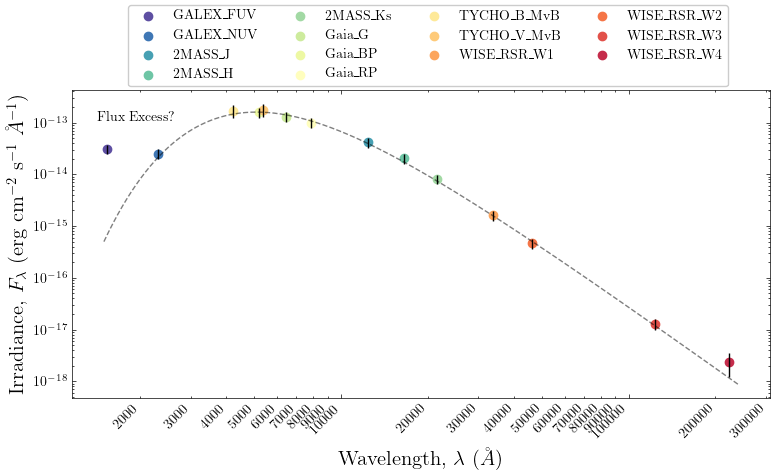

In [30]:
obs_wav, obs_flux, obs_flux_err = [], [], []

n_bands = len(bands)
cmap = cm.get_cmap('Spectral_r')
color_list = [cmap(i / n_bands) for i in range(n_bands)]
band_colors = {band: color for band, color in zip(bands, color_list)}

fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_subplot(111)

for m, merr,b, in zip(mags, magerrs, bands):
    f_, f_err = mag_to_flux(mag= m, mag_err = merr, band=b)
    f_err += 0.2*f_   # Note: Inflating uncertainty
    w_ = get_effective_wavelength(b)
    ax1.scatter(w_, f_, label=b, color=band_colors[b])
    ax1.errorbar(w_, f_, yerr=f_err, fmt='-', ecolor='k')
    obs_flux.append(f_); obs_flux_err.append(f_err); obs_wav.append(w_)
    
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.legend(framealpha=1, frameon=1, ncol=4, bbox_to_anchor=(0.95, 1.3))
ax1.set_xlabel('Wavelength, $\\lambda$ ($\\AA$)', fontsize=fs-3)
ax1.set_ylabel('Irradiance, $F_\\lambda$ (erg cm$^{-2}$ s$^{-1}$ $\\AA^{-1}$)', fontsize=fs-3)
ax1.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax1.xaxis.set_minor_formatter(mticker.ScalarFormatter())
plt.setp(ax1.get_xticklabels(minor=True), rotation=45, ha='right'); plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

wav = np.arange(1500, 240000) * u.AA
bb = BlackBody(temperature=5700*u.K); flux = bb(wav).to(u.erg/u.AA/u.s/u.sr/u.cm/u.cm, equivalencies=u.spectral_density(wav)).value
ax1.plot(wav, flux*np.pi**3.25/(dist*u.pc.to(u.cm)), alpha=0.5, c='k', ls='--')
ax1.text(x=0.035, y=0.9, s='Flux Excess?', transform=ax1.transAxes); plt.show()

obs_flux = np.array(obs_flux)[np.argsort(obs_wav)]
obs_flux_err = np.array(obs_flux_err)[np.argsort(obs_wav)]
bands = np.array(bands)[np.argsort(obs_wav)]
obs_wav = np.sort(obs_wav)

Using an arbitrarily scaled black-body spectrum, we see that a typical star should experience a decrease in flux at shorter wavelengths. The rise in flux instead suggests the presence of another, hotter source. First, let us proceed as before and try fit this star with one SED.

```{note}
Much of the code below follows from the implementation in the previous Section, and has thus been omitted for brevity.
```

In [31]:
phot_grid = pd.read_csv(str(data_folder_path) + '/CK09.csv').set_index(['met', 'teff', 'logg'])

interpolator = DFInterpolator(phot_grid)
col_to_idx = {band: i for i, band in enumerate(phot_grid.columns)}

def log_truncnorm(x, mu, sigma, lower, upper):
    """
    Fast log-probability of a truncated normal distribution.
    Equivalent to truncnorm.logpdf(x, a, b, loc=mu, scale=sigma)
    """
    # Standardized bounds
    a = (lower - mu) / sigma
    b = (upper - mu) / sigma
    z = (x - mu) / sigma

    # CDF terms for normalization
    cdf_a = 0.5 * (1 + erf(a / sqrt(2)))
    cdf_b = 0.5 * (1 + erf(b / sqrt(2)))
    norm = cdf_b - cdf_a

    # Return -inf outside bounds
    if x < lower or x > upper or norm <= 0:
        return -np.inf

    # Log-pdf of truncated normal
    logp = -0.5 * z**2 - log(sigma) - log(norm) - 0.5 * log(2 * pi)
    return logp

def log_norm(x, mu, sigma):
    """
    Fast log-probability of a normal distribution.
    Equivalent to norm.logpdf(x, a, b, loc=mu, scale=sigma)
    """
    # Standardized bounds
    z = (x - mu) / sigma
    # Log-pdf of truncated normal
    logp = -0.5 * z**2 - log(sigma) - 0.5 * log(2 * pi)
    return logp

######################   ONE MODEL FUNCTIONS ########################

def log_prior(theta):
    met, teff, logg, rad, d, Av  = theta
    mu_dist = dist; sigma_dist = 1# 10*dist_mu
    mu_av = 0; sigma_av = 0.1

    if not np.all(np.isfinite(theta)):
        print("Non-finite parameter:", theta)
        return -np.inf

    if not (-5 < met < 1 and 4000 < teff < 6500 and 0.1 < rad < 1.5):
        return -np.inf
    
    # Truncated normal on distance
    logp_dist = log_truncnorm(d,mu=mu_dist, sigma = sigma_dist, lower=0, upper=10000)
    logp_av = log_truncnorm(Av, mu = mu_av, sigma = sigma_av, 
                            lower=(0*sigma_av + mu_av), upper=(3*sigma_av + mu_av))
    logp_feh = log_norm(met, mu =-0.125, sigma=0.234)
    logp_logg = log_truncnorm(logg,mu=4, sigma = 0.5, lower=1, upper=5)

    return logp_dist + logp_av + logp_feh + logp_logg


def model_flux_emcee(params,wav,interpolator):
    met, teff, logg, rad, dist, Av  = params
    
    model = interpolator([met, teff, logg]) 
    
    if not np.all(np.isfinite(model)):
        return None
    
    model  = np.array([model[col_to_idx[b]] for b in bands])
    
    r = rad *u.solRad
    r = r.value
    d = dist * u.pc.to(u.solRad)
    norm = (r / d) ** 2
    ext = av_law(wav, Av, 3.1)

    return  apply(ext, model) * norm

def log_likelihood(params,wav, flux,sigma,interpolator):
    model = model_flux_emcee(params,wav, interpolator)
    
    if model is None:
        return -np.inf
    
    residuals = (flux - model)/sigma
    return -0.5 *np.sum( np.log(2 * np.pi * sigma**2) + residuals**2 )

def log_posterior(x,wav, flux,sigma,interpolator):
    lp = log_prior(x)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(x, wav, flux,sigma,interpolator)


nwalkers = 50
nsteps = 25000

############## ONE MODEL MCMC #################

init_vals = {
    "met": 0,
    "teff": 5000,
    "logg": 2.5,
    "rad": 1,
    "dist": dist,
    'Av': 0.1
}

Rv = 3.1
av_law = extinction.ccm89
param_order = ["met", "teff",  "logg", "rad", "dist", "Av"]
theta_init = np.array([init_vals[param] for param in param_order])
ndim = len(param_order)
p0 = theta_init + 1e-2 * np.random.randn(nwalkers, ndim)
logp_func = log_posterior
args_func = (obs_wav, obs_flux, obs_flux_err, interpolator)

sampler = emcee.EnsembleSampler(nwalkers, ndim, logp_func,
                                args=args_func)
print("Running MCMC...")
sampler.run_mcmc(p0, nsteps, progress=0)
print("Sampling complete.")

Running MCMC...
Sampling complete.


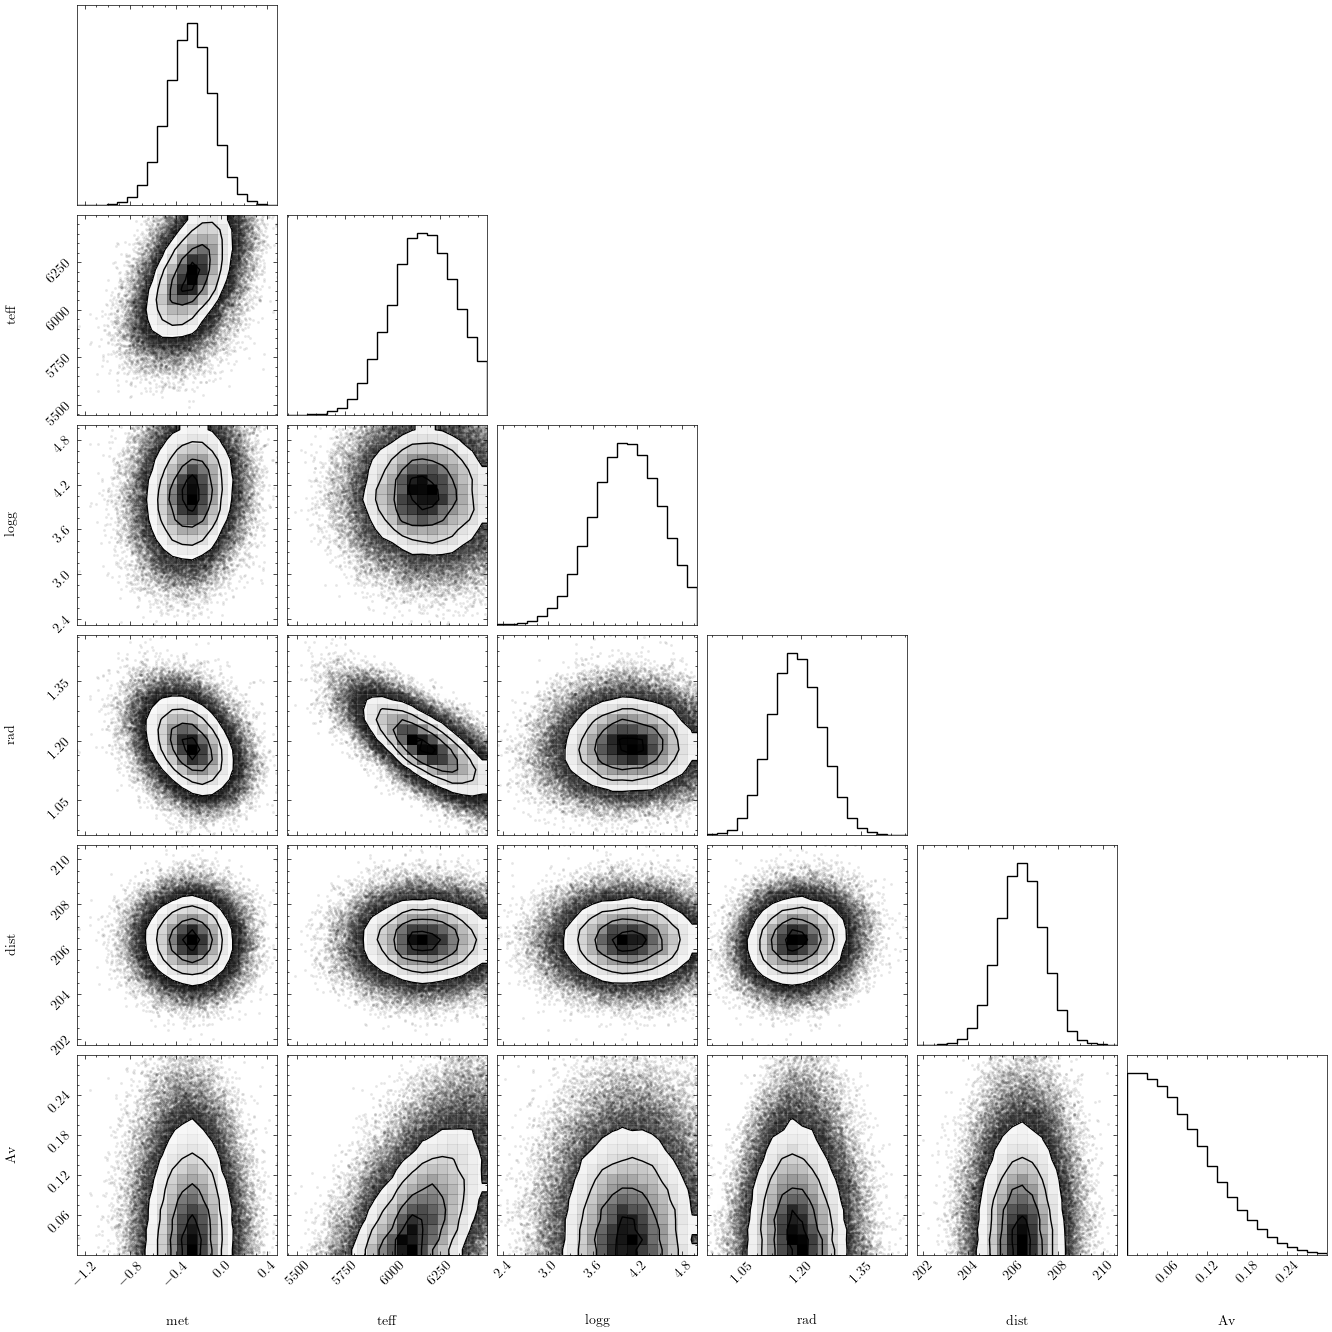

In [32]:
samples = sampler.get_chain(discard=2000, flat=True, thin=10)
import corner
fs = 15
soln_labels = param_order

fig = corner.corner(samples, labels = np.array(soln_labels)) # plotting the samples in a Corner plot!
plt.show()

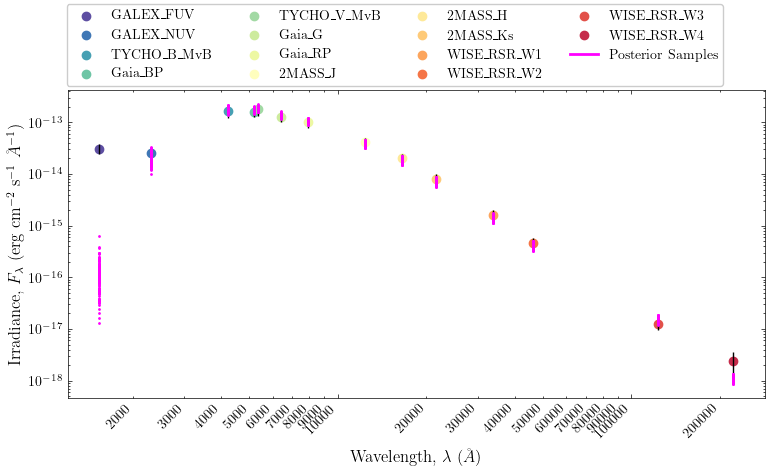

In [33]:
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_subplot(111)

color_list = [cmap(i / n_bands) for i in range(n_bands)]
band_colors = {band: color for band, color in zip(bands, color_list)}

for f_, f_err,b, in zip(obs_flux, obs_flux_err, bands):
    w_ = get_effective_wavelength(b)
    ax1.scatter(w_, f_, label=b, color=band_colors[b])
    ax1.errorbar(w_, f_, yerr=f_err, fmt='-', ecolor='k')
    
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('Wavelength, $\\lambda$ ($\\AA$)', fontsize=fs-3)
ax1.set_ylabel('Irradiance, $F_\\lambda$ (erg cm$^{-2}$ s$^{-1}$ $\\AA^{-1}$)', fontsize=fs-3)
ax1.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax1.xaxis.set_minor_formatter(mticker.ScalarFormatter())
plt.setp(ax1.get_xticklabels(minor=True), rotation=45, ha='right'); plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')


### SAMPLES FROM POSTERIOR ####
for s in samples[::1000]:
    optim_flux = model_flux_emcee(s,obs_wav, interpolator)
    ax1.scatter(obs_wav, optim_flux, s=1, c='magenta', zorder=999)
ax1.plot([],[], c='magenta', ls='-', lw=2, label='Posterior Samples')
ax1.legend(framealpha=1, frameon=1, ncol=4, bbox_to_anchor=(0.95, 1.3))
plt.show()

As seen above, the one-component SED fits reasonably well, but it many standard deviations away from the GALEX FUV measurement. Can we do better with a two-component SED?


First, we need to make some assumptions about the nature of the secondary source. Given that it produces an excess flux in the UV, it is reasonable to assume that the second source is much hotter than primary (target) source, while being of comparable luminosity (otherwise the total flux will be dominated by the secondary).


```{figure} images/hrd.png
---
height: 500px
width: 850px
name: hrd
---
Our primary star is on the main sequence. What kind of star could be hotter, yet as luminous as the primary?
```

For model spectra of the secondary, we will use the [Koester White Dwarf atmosphere models](https://ui.adsabs.harvard.edu/abs/2010MmSAI..81..921K/abstract), which should produce the desired contribution at shorter wavelengths as shown below.

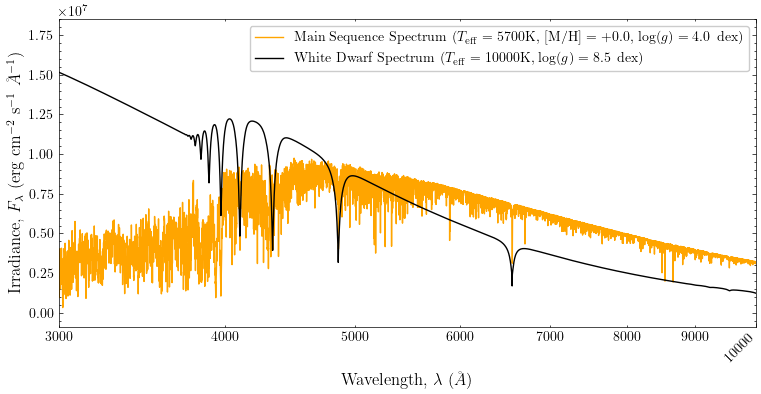

In [34]:
wddf = pd.read_csv(str(data_folder_path) + "/model_spectra/da10000_850.dk.dat.txt",
                  skiprows=6, delim_whitespace=True, header=None, names=['wave', 'flux'])

flux_conv = u.erg/u.s/(u.cm*u.cm)/u.AA
flux_conv2 = u.erg/u.s/(u.cm*u.cm)/u.cm
ph_wav_lr = fits.open(str(data_folder_path) + '/model_spectra/lte05700-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')

fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_subplot(111)

ax1.plot(ph_wav_lr[0].header['CRVAL1'] + np.arange(ph_wav_lr[0].header['NAXIS1'])*ph_wav_lr[0].header['CDELT1'],
           ph_wav_lr[0].data*flux_conv2.to(flux_conv), color='orange',
        label='Main Sequence Spectrum ($T_{\\mathrm{eff}}=5700$K, [M/H] = +0.0, $\\log(g)=4.0\\,$ dex)')
ax1.plot(wddf.wave, wddf.flux*0.12, label='White Dwarf Spectrum  ($T_{\\mathrm{eff}}=10000$K, $\\log(g)=8.5\\,$ dex)', c='k')
ax1.set_xlabel('Wavelength, $\\lambda$ ($\\AA$)', fontsize=fs-3)
ax1.set_ylabel('Irradiance, $F_\\lambda$ (erg cm$^{-2}$ s$^{-1}$ $\\AA^{-1}$)', fontsize=fs-3)
ax1.get_xticklabels()
ax1.set_xscale('log')
ax1.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax1.xaxis.set_minor_formatter(mticker.ScalarFormatter())
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.legend(frameon=1, framealpha=1)
ax1.set_xlim(3000, 10000); plt.show()
plt.show()

We will now introduce a pre-computed, interpolatable grid of synthetic white dwarf photometry.

`````{admonition} Missing a parameter?
:class: tip
Why do the white dwarf models not have a dependence on metallicity?
`````

In [35]:
models_wd = pd.read_csv(str(data_folder_path) + '/Koester_Extended_Flam.csv').set_index(['teff', 'logg'])
interpolator_wd = DFInterpolator(models_wd)
col_to_idx_wd = {band: i for i, band in enumerate(models_wd.columns)} # align observed photometry with grid columns
models_wd

2MASS_J       2MASS_H      2MASS_Ks     GALEX_NUV  \
teff  logg                                                           
5000  6.50  1.414507e+06  7.374659e+05  3.118352e+05  6.164364e+04   
      6.75  1.417164e+06  7.368323e+05  3.116441e+05  5.785754e+04   
      7.00  1.419743e+06  7.366677e+05  3.115975e+05  5.456274e+04   
      7.25  1.422192e+06  7.367574e+05  3.116378e+05  5.153634e+04   
      7.50  1.424604e+06  7.369246e+05  3.117092e+05  4.876510e+04   
...                  ...           ...           ...           ...   
80000 8.50  4.863153e+07  1.575104e+07  5.369899e+06  3.078367e+10   
      8.75  4.843354e+07  1.569018e+07  5.347963e+06  3.067968e+10   
      9.00  4.825342e+07  1.563465e+07  5.328444e+06  3.059636e+10   
      9.25  4.809952e+07  1.558632e+07  5.310709e+06  3.053349e+10   
      9.50  4.796485e+07  1.554476e+07  5.294563e+06  3.048803e+10   

               GALEX_FUV        SDSS_u        SDSS_g        SDSS_r  \
teff  logg                                                           
5000  6.50  1.563648e+02  1.855429e+06  3.690910e+06  3.896803e+06   
      6.75  1.572774e+02  1.795558e+06  3.695300e+06  3.912865e+06   
      7.00  1.573485e+02  1.734089e+06  3.698220e+06  3.927722e+06   
      7.25  1.564889e+02  1.675158e+06  3.699813e+06  3.941893e+06   
      7.50  1.546710e+02  1.619703e+06  3.699973e+06  3.955537e+06   
...                  ...           ...           ...           ...   
80000 8.50  1.301025e+11  5.899452e+09  2.112044e+09  7.369602e+08   
      8.75  1.297185e+11  5.877385e+09  2.101370e+09  7.339597e+08   
      9.00  1.294229e+11  5.858660e+09  2.091656e+09  7.312530e+08   
      9.25  1.292259e+11  5.843778e+09  2.083049e+09  7.288360e+08   
      9.50  1.291087e+11  5.831889e+09  2.075350e+09  7.266981e+08   

                  SDSS_i        SDSS_z  ...       Gaia_BP       Gaia_RP  \
teff  logg                              ...                               
5000  6.50  3.359901e+06  2.633431e+06  ...  3.723901e+06  3.143137e+06   
      6.75  3.374172e+06  2.643324e+06  ...  3.730633e+06  3.155777e+06   
      7.00  3.386926e+06  2.652096e+06  ...  3.735921e+06  3.167116e+06   
      7.25  3.398580e+06  2.660065e+06  ...  3.740264e+06  3.177594e+06   
      7.50  3.409192e+06  2.667294e+06  ...  3.743723e+06  3.187307e+06   
...                  ...           ...  ...           ...           ...   
80000 8.50  3.488528e+08  1.746400e+08  ...  1.658623e+09  3.144257e+08   
      8.75  3.476120e+08  1.739954e+08  ...  1.651131e+09  3.131610e+08   
      9.00  3.465395e+08  1.734405e+08  ...  1.644428e+09  3.120360e+08   
      9.25  3.456306e+08  1.729724e+08  ...  1.638609e+09  3.110413e+08   
      9.50  3.448563e+08  1.725594e+08  ...  1.633536e+09  3.101489e+08   

             TYCHO_B_MvB   TYCHO_V_MvB         PS1_g         PS1_r  \
teff  logg                                                           
5000  6.50  3.122570e+06  3.957883e+06  3.786901e+06  3.880716e+06   
      6.75  3.102240e+06  3.973049e+06  3.795108e+06  3.896819e+06   
      7.00  3.078814e+06  3.987306e+06  3.802031e+06  3.911677e+06   
      7.25  3.053613e+06  4.000623e+06  3.807712e+06  3.925764e+06   
      7.50  3.026983e+06  4.012868e+06  3.812023e+06  3.939218e+06   
...                  ...           ...           ...           ...   
80000 8.50  3.236899e+09  1.358082e+09  1.885040e+09  7.289167e+08   
      8.75  3.221087e+09  1.351882e+09  1.875792e+09  7.260037e+08   
      9.00  3.207282e+09  1.346188e+09  1.867363e+09  7.233848e+08   
      9.25  3.195699e+09  1.341108e+09  1.859889e+09  7.210561e+08   
      9.50  3.185992e+09  1.336572e+09  1.853203e+09  7.190051e+08   

                   PS1_i         PS1_z         PS1_w         PS1_y  
teff  logg                                                          
5000  6.50  3.337646e+06  2.772187e+06  3.624643e+06  2.334344e+06  
      6.75  3.351787e+06  2.782912e+06  3.638457e+06  2.342451e+06  
      7.00  3.364416e+06  2.7924

## Two-component SED fitting

We will assume that the total flux is the combined sum of the two stars (subscripts 1 and 2):

$$
F_{\mathrm{obs}}(\lambda) = F_{1}(\lambda) \times D_1 \times 10^{-0.4 A_1(\lambda)} + F_{2}(\lambda) \times D_2 \times 10^{-0.4 A_2(\lambda)},
$$

Assuming that these two stars are in a binary system, they are physically at the same distance, and therefore $A_1 = A_2$ and $d_1 = d_2$. The above then reduces to:

$$
F_{\mathrm{obs}}(\lambda) = \frac{10^{-0.4 A_1(\lambda)}}{d}(F_{1}(\lambda) \times R_1 + F_{2}(\lambda) \times R_2).
$$

The following code rewrites the MCMC fitting procedures for the two-component SED case:
`````{note}
Some important notes about the fitting:
- The sampling of the radius of the white dwarf is done in log units. This is because such stars are typically about 10% of the size of main-sequence stars, and using a log transform gives the sampling more dynamic range.
-  The Koester white dwarf models do not extend far into the infrared, while the CK09 models do. This means we do not have synthetic photometry for the WISE W1-4 bands. Therefore, we make the assumption that the white dwarf contributes a zero amount of flux in these bands, which is a reasonable approximation.
`````



In [36]:
######################  TWO MODEL FUNCTIONS  ########################

def log_prior_twomodel(theta):
    met1, teff1, logg1, rad1, teff2, logg2, lograd2, d, Av  = theta
    mu_dist = dist; sigma_dist = 1# 10*dist_mu
    mu_av = 0; sigma_av = 0.1

    if not np.all(np.isfinite(theta)):
        print("Non-finite parameter:", theta)
        return -np.inf

    if not (-5 < met1 < 1 and 4000 < teff1 < 6500 and 0.1 < rad1 < 1.5\
           and np.log10(0.001) <= lograd2 <= np.log10(1)):
        return -np.inf
    
    logp_dist = log_truncnorm(d,mu=mu_dist, sigma = sigma_dist, lower=0, upper=10000)
    logp_av = log_truncnorm(Av, mu = mu_av, sigma = sigma_av, 
                            lower=(0*sigma_av + mu_av), upper=(3*sigma_av + mu_av))
    logp_feh = log_norm(met1, mu =-0.125, sigma=0.234)
    logp_logg1 = log_truncnorm(logg1,mu=4, sigma = 0.5, lower=1, upper=5)
    logp_logg2 = log_truncnorm(logg2,mu=7.5, sigma = 1, lower=6.5, upper=9.5)
    logp_teff2 = log_truncnorm(teff2,mu=15000, sigma = 2000, lower=5000, upper=80000)

    return logp_dist + logp_av + logp_feh + logp_logg1 + logp_logg2 + logp_teff2


def model_flux_emcee_twomodel(params,wav,interpolator, interpolator_wd, return_models=False):
    met1, teff1, logg1, rad1, teff2, logg2, lograd2, d_, Av  = params
    
    model = interpolator([met1, teff1, logg1]) 
    model_wd = interpolator_wd([teff2, logg2]) 
    
    if not np.all(np.isfinite(model)):
        return None
    
    model  = np.array([model[col_to_idx[b]] for b in bands])
    model_wd  = np.array([model_wd[col_to_idx_wd[b]] for b in bands[:-4]]) # No WISE
    model_wd = np.append(model_wd, [0,0,0,0])
    
    r1 = (rad1 *u.solRad).value
    r2 = (10**lograd2 *u.solRad).value
    d = d_ * u.pc.to(u.solRad)
    norm1 = (r1 / d) ** 2
    norm2 = (r2 / d) ** 2

    ext = av_law(wav, Av, 3.1)
    
    if return_models:
        return norm1* (apply(ext, model)), norm2*apply(ext, model_wd)

    return  (norm1* apply(ext, model) + norm2*apply(ext, model_wd))

def log_likelihood_twomodel(params,wav, flux,sigma,interpolator, interpolator_wd):
    model = model_flux_emcee_twomodel(params,wav, interpolator, interpolator_wd)
    
    if model is None:
        return -np.inf
    
    residuals = (flux - model)/sigma
    return -0.5 *np.sum( np.log(2 * np.pi * sigma**2) + residuals**2 )

def log_posterior_twomodel(x,wav, flux,sigma,interpolator, interpolator_wd):
    lp = log_prior_twomodel(x)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_twomodel(x, wav, flux,sigma,interpolator, interpolator_wd)


Initializing and fitting the two-component model as follows:

In [37]:
# ############## TWO MODEL #################
init_vals_twomodel = {
    "met1": 0,
    "teff1": 5000,
    "logg1": 2.5,
    "rad1": 1,
    "teff2": 25000,
    "logg2": 7.5,
    "lograd2": -1,
    "dist": dist,
    'Av': 0.1,
}

param_order = ["met1", "teff1",  "logg1", "rad1",  "teff2",  "logg2", "lograd2",
               "dist", "Av"]
theta_init = np.array([init_vals_twomodel[param] for param in param_order])
ndim = len(param_order)
p0 = theta_init + 1e-2 * np.random.randn(nwalkers, ndim)
logp_func = log_posterior_twomodel
args_func = (obs_wav, obs_flux, obs_flux_err, interpolator, interpolator_wd)


sampler_twocomp = emcee.EnsembleSampler(nwalkers, ndim, logp_func,
                                args=args_func)
print("Running MCMC...")
sampler_twocomp.run_mcmc(p0, nsteps, progress=True)
print("Sampling complete.")

Running MCMC...


100%|████████████████████████████████████| 25000/25000 [03:18<00:00, 126.03it/s]

Sampling complete.


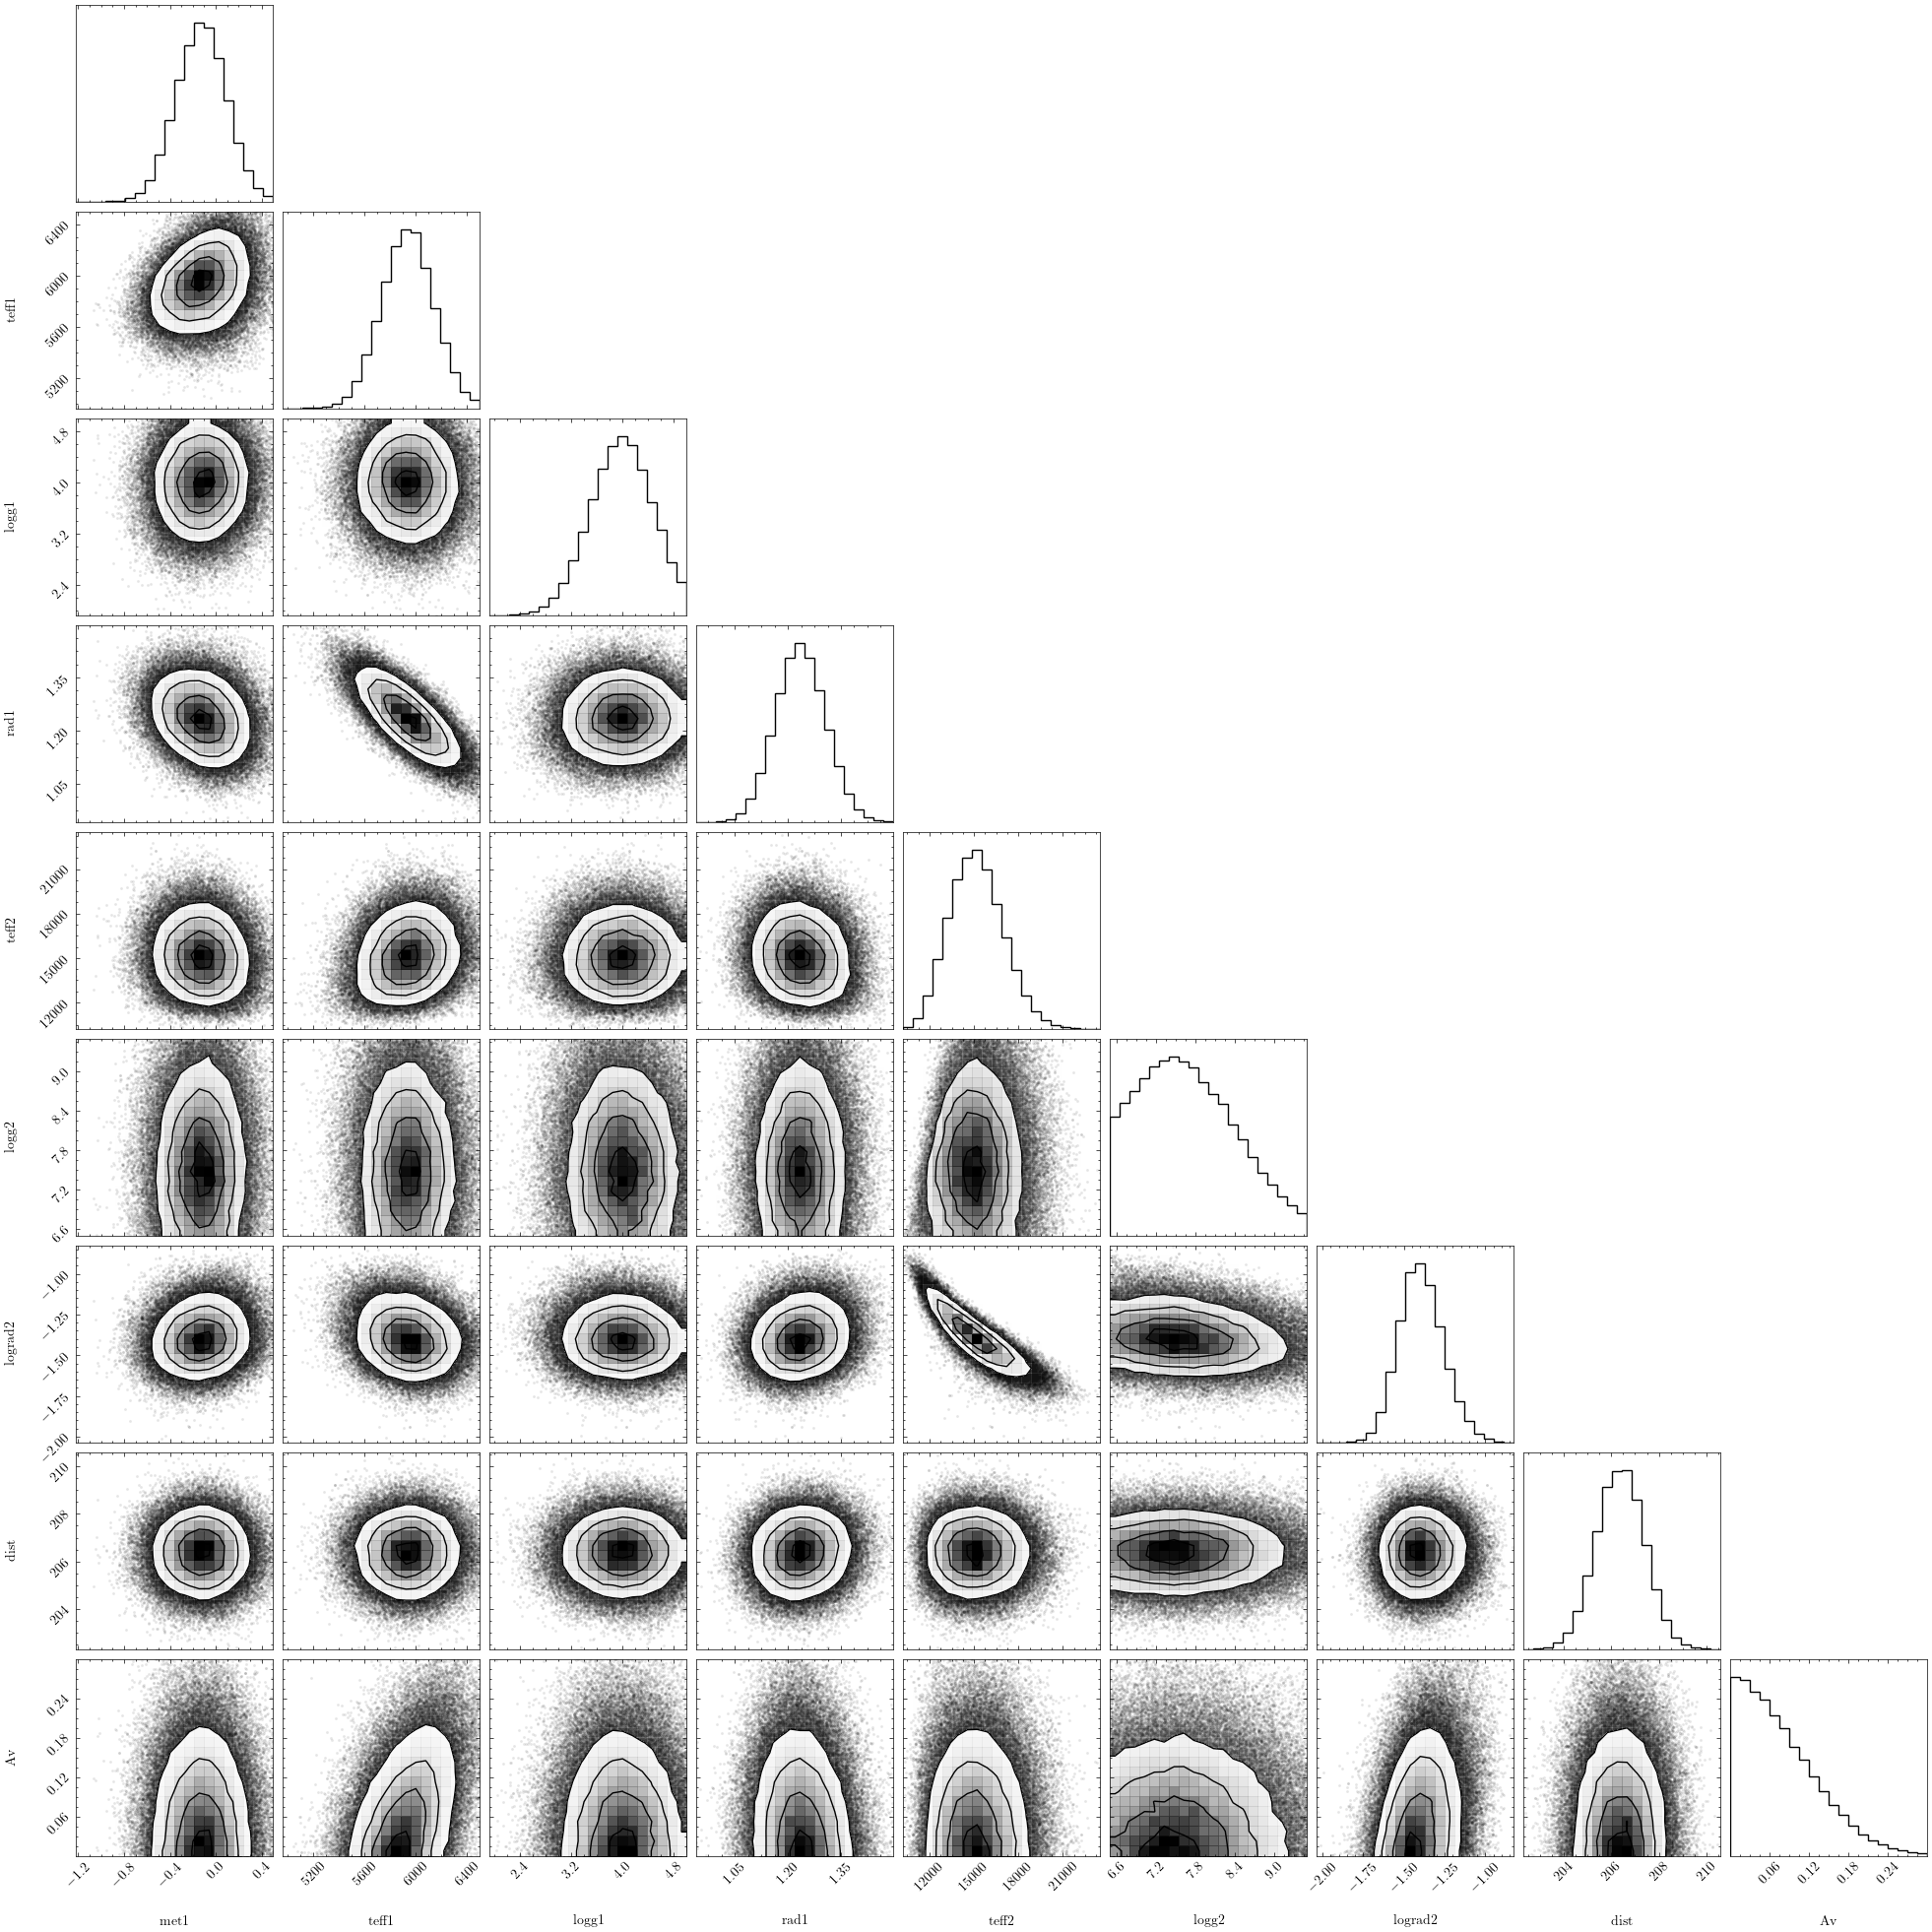

In [38]:
samples_twocomp = sampler_twocomp.get_chain(discard=2000, flat=True, thin=10)
soln_labels_twocomp = param_order

fig = corner.corner(samples_twocomp, labels = np.array(soln_labels_twocomp)) 
plt.show()

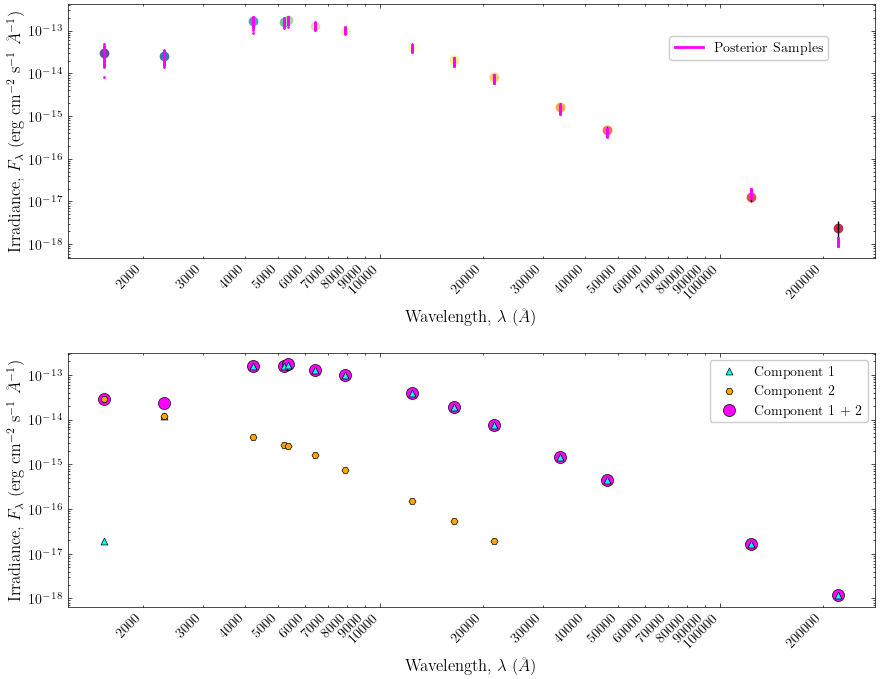

In [39]:
fig = plt.figure(figsize=(9, 7))
ax1, ax2 = fig.add_subplot(211), fig.add_subplot(212)

color_list = [cmap(i / n_bands) for i in range(n_bands)]
band_colors = {band: color for band, color in zip(bands, color_list)}

    
for i, ax in enumerate([ax1,ax2]):
    for f_, f_err,b, in zip(obs_flux, obs_flux_err, bands):
        w_ = get_effective_wavelength(b) 
        if i == 0:
            ax.errorbar(w_, f_, yerr=f_err, fmt='-', ecolor='k')
            ax.scatter(w_, f_, color=band_colors[b])
    
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel('Wavelength, $\\lambda$ ($\\AA$)', fontsize=fs-3)
    ax.set_ylabel('Irradiance, $F_\\lambda$ (erg cm$^{-2}$ s$^{-1}$ $\\AA^{-1}$)', fontsize=fs-3)
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.xaxis.set_minor_formatter(mticker.ScalarFormatter())
    plt.setp(ax.get_xticklabels(minor=True), rotation=45, ha='right'); plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
ax1.plot([],[], c='magenta', ls='-', lw=2, label='Posterior Samples')
ax1.legend(framealpha=1, frameon=1, ncol=4, bbox_to_anchor=(0.95, 0.9))

of1 = []
of2 = []

### SAMPLES FROM POSTERIOR ####
for s in samples_twocomp[::1000]:
    optim_flux1, optim_flux2 = model_flux_emcee_twomodel(s,obs_wav, interpolator, interpolator_wd,
                                                        return_models=True)
    of1.append(optim_flux1)
    of2.append(optim_flux2)

    ax1.scatter(obs_wav, optim_flux1 + optim_flux2, s=1, c='magenta', zorder=999)

ax2.scatter(obs_wav, np.median(np.array(of1), axis=0), marker='^', s=25, edgecolor='k', lw=0.5,
            color='cyan', label='Component 1')
ax2.scatter(obs_wav, np.median(np.array(of2), axis=0), marker='H', s=25, edgecolor='k', lw=0.5, 
            color='orange', label='Component 2')
ax2.scatter(obs_wav, np.median(np.array(of1), axis=0) + np.median(np.array(of2), axis=0),
            marker='o', s=75, edgecolor='k', lw=0.5, color='magenta', zorder=-99,
           label='Component 1 + 2')
ax2.legend(framealpha=1, frameon=1)
plt.tight_layout(h_pad=2)
plt.show()

## Bayesian Model Evidence from Bayes' Theorem

Bayes' theorem for a model $ M $ with parameters $ \theta $ and observed data $ y $ is:

$$
p(\theta \mid y, M) = \frac{p(y \mid \theta, M) \, p(\theta \mid M)}{p(y \mid M)}.
$$

This expresses the posterior as a product of the likelihood and the prior, normalized by the **model evidence** (also called the **marginal likelihood**):

- $ p(\theta \mid y, M) $: posterior distribution  
- $ p(y \mid \theta, M) $: likelihood  
- $ p(\theta \mid M) $: prior  
- $ p(y \mid M) $: model evidence  

An equivalent notation commonly used in Bayesian computation is:

$$
p(\theta \mid y, M) = \frac{\mathcal{L}(\theta) \, \pi(\theta)}{z},
$$

where:
- $ \mathcal{L}(\theta) := p(y \mid \theta, M) $ is the likelihood,
- $ \pi(\theta) := p(\theta \mid M) $ is the prior,
- $ z := p(y \mid M) $ is the marginal likelihood (evidence).

### Definition of Evidence

$$
p(y \mid M) = z = \int p(y \mid \theta, M) \, p(\theta \mid M) \, d\theta.
$$

The model evidence is the integral of the joint likelihood and prior **over the parameter space**. It quantifies both how well the model explains the data *and* how plausible that explanation is under the prior.

This integral captures both the fit of the model to the data and the complexity of the model. Models that overfit tend to have higher likelihoods on a narrow region of parameter space, leading to smaller integrals. As such, Bayesian model selection automatically **penalizes model complexity**.

```{figure} images/occam.png
---
height: 400px
width: 600px
name: occam
---
Schematic of Bayesian model evidence. A simpler model concentrates prior mass on fewer datasets (higher prior predictive probability per dataset), while a complex model spreads prior mass over many datasets (lower prior predictive probability per dataset). In other words, a complex model has the potential of fitting many different types of datasets prior to fitting. Image from [Ghahramani (2013)](https://royalsocietypublishing.org/doi/10.1098/rsta.2011.0553).
```


### Evidence in Model Comparison

Bayesian model comparison is performed by computing the evidence for each model and comparing their relative probabilities:

$$
\frac{p(M_1 \mid y)}{p(M_2 \mid y)} = \frac{p(y \mid M_1)}{p(y \mid M_2)} \cdot \frac{p(M_1)}{p(M_2)}.
$$


`````{admonition} Another approach to defining Bayesian model comparison
:class: tip

For a set of models $ \{ {M}_i \} $, Bayes’ theorem yields the posterior probability of each candidate model given observed data $ y $:

$$
p({M}_i \mid y) = \frac{p(y \mid {M}_i) \, p({M}_i)}{p(y)},
$$

where:
- $ p({M}_i) $ is the prior probability of model $ {M}_i $,
- $ p(x \mid {M}_i) $ is the marginal likelihood or **model evidence**, and
- $ p(x) = \sum_j p(y \mid {M}_j) p({M}_j) $ is the model-normalizing constant.

When comparing two models $ {M}_1 $ and $ {M}_2 $, the ratio of their posterior probabilities is:

$$
\frac{p({M}_1 \mid y)}{p({M}_2 \mid y)} = \frac{p(y \mid {M}_1)}{p(y \mid {M}_2)} \cdot \frac{p({M}_1)}{p({M}_2)},
$$

which indicates that model selection depends both on how well the model explains the data and the prior belief in the model.
`````

## The Harmonic Mean Estimator (HME)

Introduced by [Newton and Rafterty (1994)](https://www.jstor.org/stable/2346025), the HME is a simple approach for estimating model evidence and enabling model comparisons. From Bayes' theorem, we have

$$
p(\theta \mid y) = \frac{\mathcal{L}(\theta)\, \pi(\theta)}{z}. 
$$

where $\mathcal{L}(\theta)$ is the likelihood and $\pi(\theta)$ is the prior. We aim to estimate the model evidence $ z = p(y) $ given posterior samples. Let us draw samples from the posterior and compute the inverse of the likelihood:

$$
\mathbb{E}_{p(\theta \mid y)}\left[ \frac{1}{\mathcal{L}(\theta)} \right]
= \int \frac{1}{\mathcal{L}(\theta)} \, p(\theta \mid y) \, d\theta.
$$

Note the following:

$$
\int \frac{1}{\mathcal{L}(\theta)} \, p(\theta \mid y) \, d\theta = \int \frac{1}{\mathcal{L}(\theta)} \cdot \frac{\mathcal{L}(\theta)\, \pi(\theta)}{z} \, d\theta = \frac{1}{z} \int \pi(\theta) \, d\theta = \frac{1}{z},
$$

since $ \pi(\theta) $ is a normalized prior distribution.
Given samples $ \{ \theta_j \}_{j=1}^N $ drawn from the posterior distribution $ p(\theta \mid y) $, the harmonic mean estimator $ \hat{z}_{\text{HME}} $ provides an approximation of the model evidence as the following:

$$
\hat{z}_{\text{HME}} = \left( \frac{1}{N} \sum_{i=1}^N \frac{1}{\mathcal{L}(\theta_i)} \right)^{-1},
$$

where $\mathcal{L}$ is the likelihood. Rewriting this differently:

$$
\frac{1}{\hat{z}_{\text{HME}}} = \int \frac{p(\theta \mid y) }{\mathcal{L}(\theta)}\,d\theta.
$$

The HME thus **requires only posterior samples and evaluations of the likelihood.**

However, it may be unreliable in high-dimensional settings or when the posterior is weakly concentrated. In these scenarios, the estimator can place disproportionate weight on samples where the likelihood $\mathcal{L} $ is small, which blows up the quantity $\hat{z}_{\text{HME}}$. Because of this, the HME is thought to suffer from **high variance**.


`````{admonition} HME in the context of importance sampling
:class: tip

Compare this with the importance sampling identity, which states:

$$
\mathbb{E}_{q(\theta)}\left[ \frac{k(\theta)}{q(\theta)} f(\theta) \right] = \int f(\theta) \, k(\theta) \, d\theta.
$$


We see that $ 1/p(y \mid M) $ is equivalent to the expectation of the **reciprocal likelihood** under the posterior:

$$
\frac{1}{\hat{z}_{\text{HME}}} = \int \frac{1}{z} \frac{\pi(\theta)}{p(\theta \mid y)}\,p(\theta \mid y)\,d\theta.
$$

Thus, the Harmonic Mean Estimator is a form of importance sampling where:
- The **target distribution** $k(\theta)$  is the prior $\pi(\theta) $,
- The **proposal distribution** $k(\theta)$ is the posterior $ p(\theta \mid y) $,

This equivalence reveals the key weakness: in importance sampling you need to have your proposal distribution to span a wider range in parameter space (i.e., fatter tails) than the target distribution. This is often not the case for the above definition of the prior as the target and the posterior as the proposal. As a result, the HME is said to contain a large variance, by placing too much emphasis on parameter values where the likelihood is small, even if those values are sampled infrequently under the posterior. 



`````

## The Learned Harmonic Mean Estimator (LHME)

Generalizing the importance sampling definition of the harmonic mean estimator, we have 

$$
\frac{1}{\hat{z}} = \int \frac{1}{z} \frac{\psi(\theta)}{p(\theta \mid y)}\,p(\theta \mid y)\,d\theta,
$$

where the function $\psi(\theta)$ can be any distribution as long as it is normalized. Ideally, we want the proposal distribution, i.e., the posterior $p(\theta \mid y)$, **to not only wholly encapsulate $\psi(\theta)$, but to match the distribution of the posterior as closely as possible**. The optimal distribution for $\psi(\theta)$, is of course the posterior distribution itself!

The insight from [McEwen et al. 2021](https://arxiv.org/abs/2111.12720) and [Polanska et al. 2024](https://arxiv.org/abs/2405.05969) is that the optimal $\psi(\theta)$ can be learnt using normalizing flows. In other words, we have:

$$
\mathbb{E}_{p(\theta \mid y)}\left[ \frac{\psi(\theta)}{\mathcal{L}(\theta)} \right]
= \left( \frac{1}{N} \sum_{i=1}^N \frac{\psi(\theta_i)}{\mathcal{L}(\theta_i)} \right),
$$

where $\psi(\theta)$ is trained to mimic the posterior distribution. 

The library [`harmonic`](https://astro-informatics.github.io/harmonic/index.html) implements this utility. Let's run the LHME over the one-component SED scenario to get its evidence estimate, first by training a normalizing flow.

In [40]:
import harmonic as hm

samples = np.ascontiguousarray(np.transpose(sampler.get_chain(discard=2000, flat=False, thin=10), (1, 0, 2)))
lnprob = np.ascontiguousarray(np.transpose(sampler.get_log_prob(discard=2000, flat=False, thin=10), (1, 0)))

chains = hm.Chains(len(init_vals))
chains.add_chains_3d(samples, lnprob)
chains_train, chains_infer = hm.utils.split_data(chains, training_proportion=0.75)

2025-04-30 09:32:42.354456: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2025-04-30 09:32:42.354524: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2025-04-30 09:32:42.354532: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [41]:
temperature = 0.8

model = hm.model.RQSplineModel(len(init_vals), standardize=True, temperature=temperature, n_bins=16)
epochs_num = 20
# Train normalizing flow model
model.fit(chains_train.samples, epochs=epochs_num, verbose= True)

Training NF: 100%|██████████████████████████████| 20/20 [02:01<00:00,  6.06s/it]


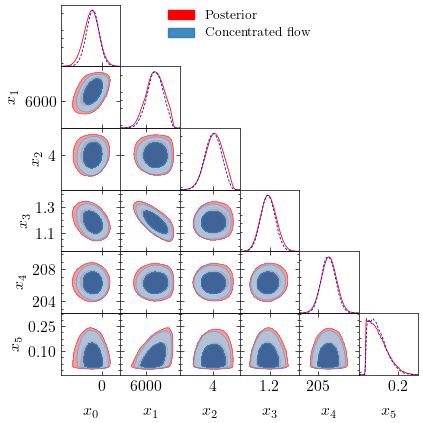

In [42]:
samples = samples.reshape((-1, len(init_vals)))
samp_num = samples.shape[0]
flow_samples = model.sample(samp_num)
hm.utils.plot_getdist_compare(samples, flow_samples)

Recall that the goal is to maximize the coverage of the posterior distribution **over** the concentrated flow. Next, we estimate the log evidence for the one-component SED scenario:

In [43]:
# Instantiate harmonic's evidence class
ev = hm.Evidence(chains_infer.nchains, model)

# Pass the evidence class the inference chains and compute the evidence!
ev.add_chains(chains_infer)
ln_inv_evidence_one_sed  = ev.ln_evidence_inv
print(f'One-component SED fit Log Evidence: {-ln_inv_evidence_one_sed}')

One-component SED fit Log Evidence: 451.1123046875


Now let's do the same for the two-component SED model.

In [44]:
samples_two = np.ascontiguousarray(np.transpose(sampler_twocomp.get_chain(discard=2000, flat=False, thin=10), (1, 0, 2)))
lnprob_two = np.ascontiguousarray(np.transpose(sampler_twocomp.get_log_prob(discard=2000, flat=False, thin=10), (1, 0)))

chains_two = hm.Chains(len(init_vals_twomodel))
chains_two.add_chains_3d(samples_two, lnprob_two)
chains_two_train, chains_two_infer = hm.utils.split_data(chains_two, training_proportion=0.75)

In [45]:
model_two = hm.model.RQSplineModel(len(init_vals_twomodel), standardize=True, temperature=temperature, n_bins=16)
epochs_num = 20
# Train normalizing flow model
model_two.fit(chains_two_train.samples, epochs=epochs_num, verbose= True)

Training NF: 100%|██████████████████████████████| 20/20 [02:04<00:00,  6.21s/it]


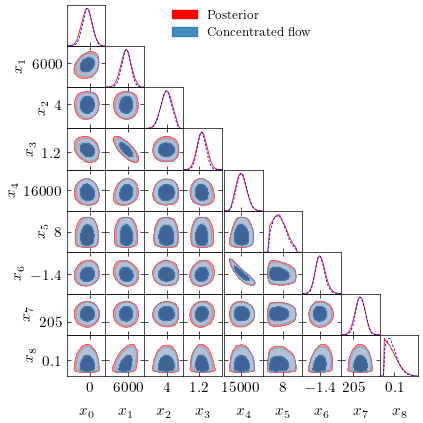

In [46]:
samples_two = samples_two.reshape((-1, len(init_vals_twomodel)))
flow_samples_two = model_two.sample(samples_two.shape[0])
hm.utils.plot_getdist_compare(samples_two, flow_samples_two)

In [47]:
# Instantiate harmonic's evidence class
ev_two = hm.Evidence(chains_two_infer.nchains, model_two)
# Pass the evidence class the inference chains and compute the evidence!
ev_two.add_chains(chains_two_infer)
ln_inv_evidence_two_sed  = ev_two.ln_evidence_inv
print(f'Two-component SED fit Log Evidence: {-ln_inv_evidence_two_sed}')

Two-component SED fit Log Evidence: 461.00140380859375


In [50]:
bayes_factor_ln = -ln_inv_evidence_two_sed - -ln_inv_evidence_one_sed
print(f'Bayes Factor (Two-to-One Component): {np.exp(bayes_factor_ln):.3f}')

Bayes Factor (Two-to-One Component): 19714.291


The following **Jeffreys' Scale** quantify how much more likely the data are under Model 2 ($M_2$) compared to Model 1 ($M_1$) using the Bayes factor $ p(y \mid M_2) / p(y \mid M_1) $. The table below provides qualitative interpretation thresholds based on the **magnitude** of the Bayes factor.

| Bayes Factor  | Strength of Evidence for $ M_2 $ over $ M_1 $ |
|------------------------|------------------------------------------|
| $ < 1 $              | Evidence favors $ M_1 $                |
| $ 1 $ to $ 3 $     | Barely worth mentioning                  |
| $ 3 $ to $ 10 $    | Substantial evidence                     |
| $ 10 $ to $ 30 $   | Strong evidence                          |
| $ 30 $ to $ 100 $  | Very strong evidence                     |
| $ > 100 $            | Decisive evidence         |


We thus see that the two-component SED is strongly favoured over the one-component SED in this scenario.


`````{admonition} Exercise

1. How does the evidence calculated using the Learned Mean Harmonic Estimator compare with the original Mean Harmonic Estimator, calculated as 

```
likelihoods = np.array([likelihood_fn(theta) for theta in posterior_samples])
evidence_estimate = 1.0 / np.mean(1.0 / likelihoods)
```

2. The example below is a specific case of a white dwarf that appears to have an excess in the infrared. Fit a single white dwarf SED model (using Koester models), calculate the evidence, and then determine if a white dwarf + brown dwarf two-component SED (using CK09) is better justified.

The `flux_uncertainty_inflation` variable below artificially inflates the uncertainty of the flux measurements. How does the Bayes factor between the two fits change when you modify this variable? Why?

3. Go back to the example in {ref}`content:references:sed_part2` and determine if there is evidence for two sources in the SED using the Learned Harmonic Mean Estimator.

`````



In [6]:
with open(os.path.join(data_folder_path, 'phot_data') +"/wd-bd.yaml", "r") as f:
    data = yaml.safe_load(f)

dist = data["distance_pc"] # Distance in parsec

bands = [entry["band"] for entry in data["photometry"]] # Extract band-wise values
mags = [entry["mag"] for entry in data["photometry"]]
magerrs = [entry["mag_err"] for entry in data["photometry"]]

print('Star ID: ', data["starname"]) # Star name 
for m, me, b in zip(mags, magerrs, bands): # print band name and apparent magnitude and error
    print(m, me,b)

Star ID:  GD 1400
16.4044 0.0239 GALEX_FUV
15.6508 0.0103 GALEX_NUV
14.923 0.032 2MASS_J
14.45 0.045 2MASS_H
14.335 0.064 2MASS_Ks
15.210746 0.02 Gaia_G
15.231833 0.02 Gaia_BP
15.178323 0.02 Gaia_RP
13.789 0.028 WISE_RSR_W1
13.623 0.039 WISE_RSR_W2
12.838 0.531 WISE_RSR_W3


In [21]:
flux_uncertainty_inflation = 0.2

/tmp/ipykernel_30688/3494858413.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Spectral_r')


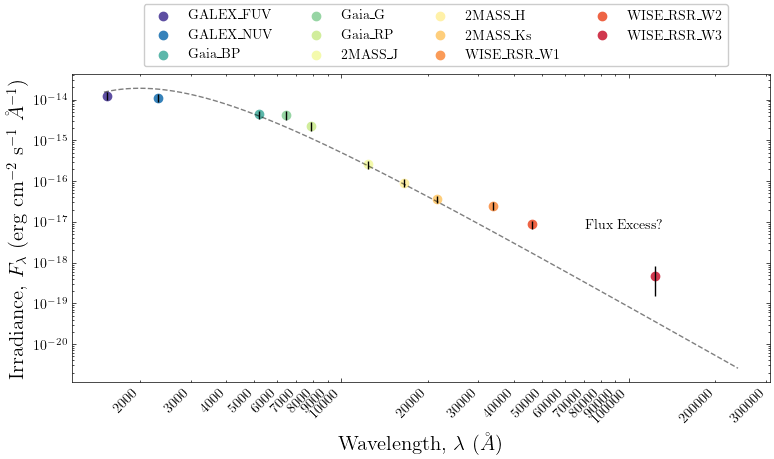

In [28]:
obs_wav, obs_flux, obs_flux_err = [], [], []

n_bands = len(bands)
cmap = cm.get_cmap('Spectral_r')
color_list = [cmap(i / n_bands) for i in range(n_bands)]
band_colors = {band: color for band, color in zip(bands, color_list)}

fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_subplot(111)

for m, merr,b, in zip(mags, magerrs, bands):
    f_, f_err = mag_to_flux(mag= m, mag_err = merr, band=b)
    f_err += flux_uncertainty_inflation*f_   # Note: Inflating uncertainty
    w_ = get_effective_wavelength(b)
    ax1.scatter(w_, f_, label=b, color=band_colors[b])
    ax1.errorbar(w_, f_, yerr=f_err, fmt='-', ecolor='k')
    obs_flux.append(f_); obs_flux_err.append(f_err); obs_wav.append(w_)
    
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.legend(framealpha=1, frameon=1, ncol=4, bbox_to_anchor=(0.95, 1.25))
ax1.set_xlabel('Wavelength, $\\lambda$ ($\\AA$)', fontsize=fs-3)
ax1.set_ylabel('Irradiance, $F_\\lambda$ (erg cm$^{-2}$ s$^{-1}$ $\\AA^{-1}$)', fontsize=fs-3)
ax1.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax1.xaxis.set_minor_formatter(mticker.ScalarFormatter())
plt.setp(ax1.get_xticklabels(minor=True), rotation=45, ha='right'); plt.setp(ax1.get_xticklabels(), 
                                                                             rotation=45, ha='right')

wav = np.arange(1500, 240000) * u.AA
bb = BlackBody(temperature=14500*u.K); flux = bb(wav).to(u.erg/u.AA/u.s/u.sr/u.cm/u.cm, equivalencies=u.spectral_density(wav)).value
ax1.plot(wav, flux*0.003*np.pi/(dist*u.pc.to(u.cm)), alpha=0.5, c='k', ls='--')
ax1.text(x=0.735, y=0.5, s='Flux Excess?', transform=ax1.transAxes); plt.show()

obs_flux = np.array(obs_flux)[np.argsort(obs_wav)]
obs_flux_err = np.array(obs_flux_err)[np.argsort(obs_wav)]
bands = np.array(bands)[np.argsort(obs_wav)]
obs_wav = np.sort(obs_wav)

## See also

[iNNterpol: High-precision interpolation of stellar atmospheres with a deep neural network using a 1D convolutional auto encoder for feature extraction](https://github.com/cwestend/iNNterpol/tree/main)

Prediction and interpolation of model atmospheres using convolutional autoencoders
